In [5]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

## Loading Dataset and Setting up the Data generators

In [6]:
train_directory=r'D:\Machine learning for data analysis\EDA Dataset\COVID-19_Radiography_Dataset\train'
val_directory=r'D:\Machine learning for data analysis\EDA Dataset\COVID-19_Radiography_Dataset\validation'

In [7]:
Datagen=ImageDataGenerator(rescale=1./255)


train_generator = Datagen.flow_from_directory(
        directory=train_directory,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True)
val_generator = Datagen.flow_from_directory(
        directory=val_directory,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True)

Found 13810 images belonging to 4 classes.
Found 403 images belonging to 4 classes.


## Setting up models (VGG16,Resnet50)

In [10]:
# VGG16
VGG_base=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))


In [11]:
x=VGG_base.output
x=GlobalAveragePooling2D()(x)
#x=Dropout(0.5)(x)
out=Dense(4,activation='softmax')(x)
VGG_model=Model(inputs=VGG_base.input,outputs=out)
VGG_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
# Resnet50

resnet_base=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

D:\ML\envs\ssd\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 77s 1us/step


In [15]:
x1=resnet_base.output
x1=GlobalAveragePooling2D()(x1)
#x1=Dropout(0.7)
out1=Dense(4,activation='softmax')(x1)
resnet_model=Model(inputs=resnet_base.input,outputs=out1)
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# custom model

## Model Training

In [17]:
# training log
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
model_checkpoint = ModelCheckpoint(filepath='Covid-VGG-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',  # REPLACE WITH 'RESNET' WHILE STORING RESNET
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='covid-vgg-training_log.csv',
                       separator=',',
                       append=True)

#learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,verbose=1),when doing this add this to call backs

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             terminate_on_nan]

In [18]:
from keras.optimizers import Adam, SGD
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)



In [20]:
# VGG model training

VGG_model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

batch_size=16
initial_epoch=0
final_epoch=10
steps_per_epoch=13810//16
val_steps=403 //16

history = VGG_model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=val_steps,
                              initial_epoch=initial_epoch)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
863/863 [==============================] - 3749s 4s/step - loss: 0.6284 - acc: 0.7454 - val_loss: 0.5104 - val_acc: 0.8150

Epoch 00001: val_loss improved from inf to 0.51043, saving model to Covid-VGG-01_loss-0.6284_val_loss-0.5104.h5
Epoch 2/10
863/863 [==============================] - 3997s 5s/step - loss: 0.3450 - acc: 0.8736 - val_loss: 0.2912 - val_acc: 0.9000

Epoch 00002: val_loss improved from 0.51043 to 0.29121, saving model to Covid-VGG-02_loss-0.3450_val_loss-0.2912.h5
Epoch 3/10
863/863 [==============================] - 3661s 4s/step - loss: 0.2661 - acc: 0.9053 - val_loss: 0.3792 - val_acc: 0.8359

Epoch 00003: val_loss did not improve from 0.29121
Epoch 4/10
863/863 [==============================] - 3931s 5s/step - loss: 0.2459 - acc: 0.9129 - val_loss: 0.1899 - val_acc: 0.9500

Epoch 00004: val_loss improved from 0.29121 to 0.18987, saving model to Covid-VGG-04_l

KeyboardInterrupt: 

In [ ]:
# Resnet model training

resnet_model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


batch_size=16
initial_epoch=0
final_epoch=10
steps_per_epoch=13810//16
val_steps=403 //16

history_resnet = resnet_model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=val_steps,
                              initial_epoch=initial_epoch)

### Training results

In [42]:
import pandas as pd

results_df=pd.read_csv(r'C:\Users\svsar\projects\EDA\covid-vgg-training_log.csv')
results_df

,epoch,acc,loss,val_acc,val_loss
0,0,0.745365,0.628408,0.815000,0.510435
1,1,0.873552,0.344950,0.900000,0.291209
2,2,0.905190,0.266265,0.835897,0.379182
3,3,0.912949,0.245915,0.950000,0.189875
4,4,0.930415,0.201061,0.923077,0.243662
5,5,0.933806,0.182033,0.970000,0.123833
6,6,0.940128,0.165182,0.958974,0.161437
7,7,0.942352,0.157118,0.955000,0.159968
8,8,0.946796,0.140515,0.953846,0.187465


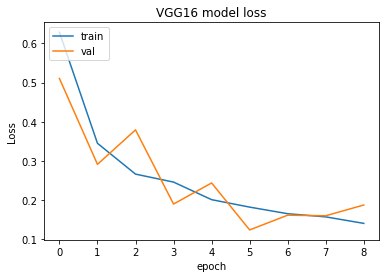

In [43]:
import matplotlib.pyplot as plt

plt.plot(results_df['epoch'],results_df['loss'])
plt.plot(results_df['epoch'],results_df['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

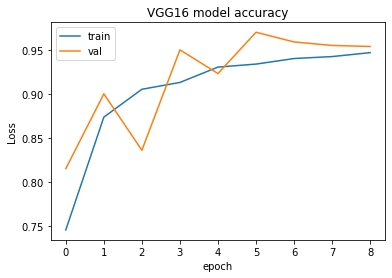

In [44]:
plt.plot(results_df['epoch'],results_df['acc'])
plt.plot(results_df['epoch'],results_df['val_acc'])
plt.title('VGG16 model accuracy')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results

In [29]:
print(train_generator.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [30]:
# Prediction using VGG model
import numpy as np
import cv2
import os

test_img=cv2.imread(r'D:\Machine learning for data analysis\EDA Dataset\COVID-19_Radiography_Dataset\test\COVID\COVID-1.png')
test_img=cv2.resize(test_img,(224,224))
test_img=test_img/255
y_pred=VGG_model.predict(np.array([test_img]))
print(np.argmax(y_pred))

0


In [32]:
#computing accuracy of VGG model
test_directory=r'D:\Machine learning for data analysis\EDA Dataset\COVID-19_Radiography_Dataset\test'
correct_pred=0
total=0

for i,clas in enumerate(os.listdir(test_directory)):
    path=os.path.join(test_directory,clas)
    images=os.listdir(path)
    for img in images:
        test_img=cv2.imread(os.path.join(path,img))
        test_img=cv2.resize(test_img,(224,224))
        test_img=test_img/255
        y_pred=VGG_model.predict(np.array([test_img]))
        if np.argmax(y_pred)==i:
            correct_pred+=1
    total+=len(images)

In [34]:
acc=correct_pred/total

In [37]:
print('The Accuracy of VGG16 Model is ' + str(acc*100))

The Accuracy of VGG16 Model is 96.15384615384616
